In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Scintillation data bottom 1107

In [2]:
# dir1007 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/"
# subdir1007 = ["2022-10-07_volt_65_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_67_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_69_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_71_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_73_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_75_pos_top_light_scint_coinc_111"]
# dscrp1007 = ["65V", "67V", "69V", "71V", "73V", "75V"]
# bias = [65, 67, 69, 71, 73, 75]

# dir1104_bg = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_no_gamma'
# dir1104_cs = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_with_gamma'

dir1107_bkg = []
dir1107_gamma = []
for i in range(6):
    dir1107_bkg.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_no_gamma_purification_{}'.format(i+1))
    dir1107_gamma.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_{}'.format(i+1))


In [3]:
ds1107_bkg = []
ds1107_gamma = []
for i,subdir in enumerate(dir1107_bkg+dir1107_gamma):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=[518.84503, 510.84132, 504.40531, 457.59589])
    for j in range(10):
        data.path = "{}/{}/".format(subdir, j)
        if j<=6 or i!=4:
            for ch in range(4):
                data.ch[ch].path = data.path
                data.ch[ch].read_data()
                data.ch[ch].baseline_subtraction()
                data.ch[ch].get_integral(prompt=0.5, long=5)
                data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 20*data.gain[ch]])
                data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    if i<len(dir1107_bkg):
        ds1107_bkg.append(data)
    else:
        ds1107_gamma.append(data)

## $f_{\rm prompt}$ distribution
Prompt integral = $0.5~\rm{\mu s}$ integrated charge
Total integral = $5~\rm{\mu s}$ integrated charge

Text(0.5, 0.98, 'Cs-137 + Backgrounds')

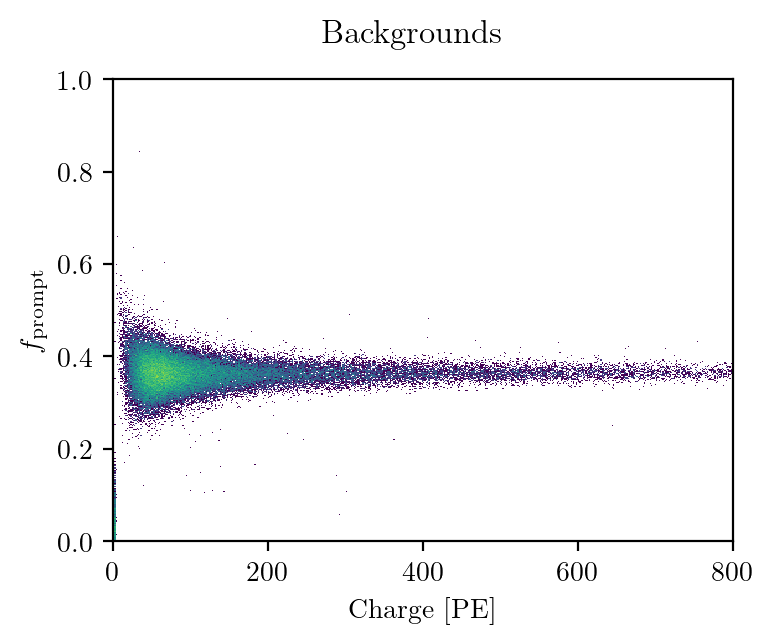

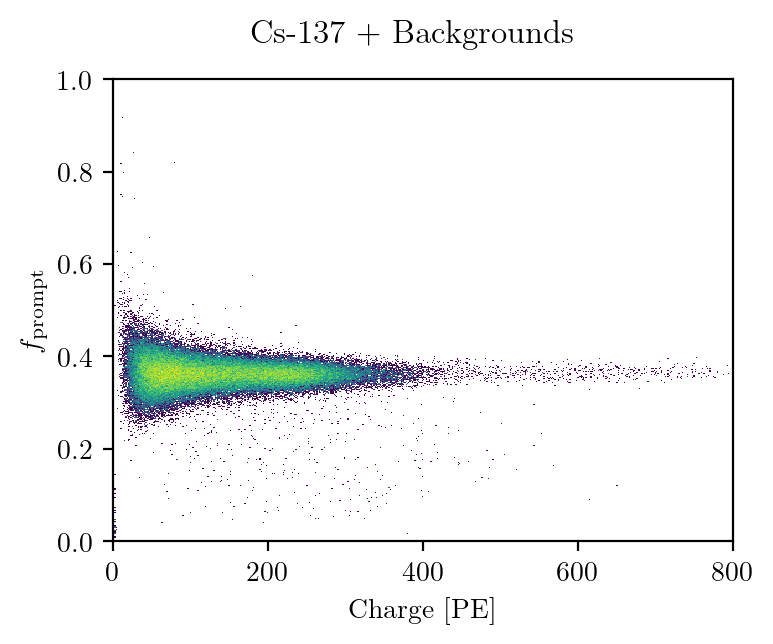

In [4]:
import matplotlib.colors as colors
plt.figure(0)
dset = ds1107_bkg[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Backgrounds')
plt.figure(1)
dset = ds1107_gamma[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Cs-137 + Backgrounds')

## Spectrum of $5~\rm{\mu s}$ integrated charge

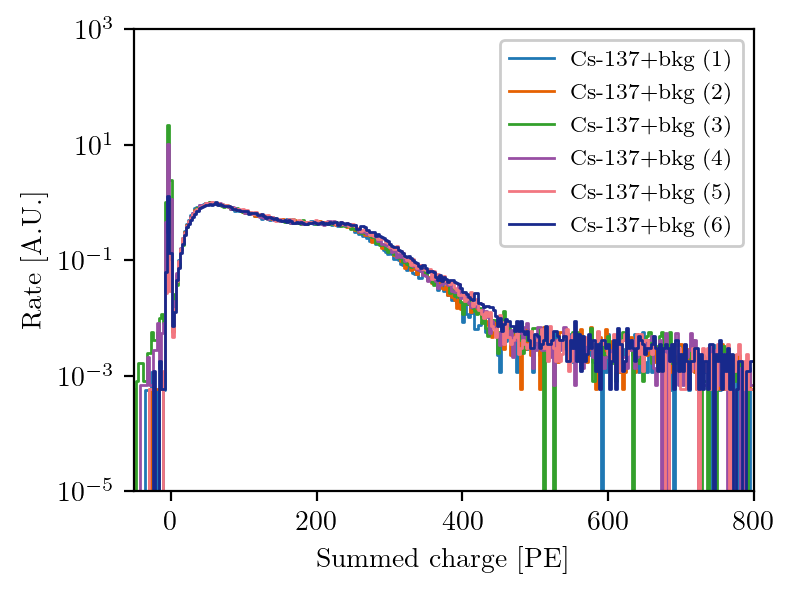

In [5]:
xmin = -50
xmax = 800
nbins = 300
bin_width = (xmax-xmin)/nbins
labels = []
for i in range(len(ds1107_gamma)):
    labels.append('Cs-137+bkg ({})'.format(i+1))
plt.figure()
hist = []
for i in range(len(ds1107_gamma)):
    dset = ds1107_gamma[i]
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/np.max(h[20:])
    #h = h/ds.ch[0].cumulative_time/bin_width
    hist.append(h)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-5, 1e3)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [A.U.]')
plt.show()

## Triplet lifetime

ch0 A_S=322.730+/-26.309  TAU_S=0.0465+/-0.0033us  A_T=36.947+/-0.042  TAU_T=0.7764+/-0.0007us
ch1 A_S=134.100+/-0.671  TAU_S=0.1818+/-0.0012us  A_T=25.111+/-0.135  TAU_T=1.5921+/-0.0067us
ch2 A_S=78440380.465+/-287283630017.104  TAU_S=0.0000+/-0.0014us  A_T=28.657+/-0.107  TAU_T=1.2271+/-0.0033us
ch3 A_S=117588994.690+/-661372556233.377  TAU_S=0.0000+/-0.0016us  A_T=18.205+/-0.105  TAU_T=2.0668+/-0.0106us
ch0 A_S=325.158+/-26.865  TAU_S=0.0465+/-0.0034us  A_T=37.959+/-0.042  TAU_T=0.7831+/-0.0007us
ch1 A_S=136.880+/-0.699  TAU_S=0.1788+/-0.0012us  A_T=26.648+/-0.137  TAU_T=1.5691+/-0.0064us
ch2 A_S=80138930.241+/-297148586238.548  TAU_S=0.0000+/-0.0014us  A_T=30.043+/-0.104  TAU_T=1.2373+/-0.0031us
ch3 A_S=110520814.888+/-663988908151.585  TAU_S=0.0000+/-0.0018us  A_T=19.186+/-0.120  TAU_T=2.0238+/-0.0112us
ch0 A_S=220.277+/-12.922  TAU_S=0.0498+/-0.0026us  A_T=27.432+/-0.034  TAU_T=0.8134+/-0.0008us
ch1 A_S=95.401+/-0.502  TAU_S=0.1888+/-0.0013us  A_T=18.211+/-0.105  TAU_T=1.6659+/-0

/home/as111/sipm-analysis/sipm/sipm.py:328: RuntimeWarning: overflow encountered in exp
  s3 = self.a1*a_s*tau_s*self.tau1*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau1))/(tau_s-self.tau1)
/home/as111/sipm-analysis/sipm/sipm.py:328: RuntimeWarning: overflow encountered in divide
  s3 = self.a1*a_s*tau_s*self.tau1*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau1))/(tau_s-self.tau1)
/home/as111/sipm-analysis/sipm/sipm.py:329: RuntimeWarning: overflow encountered in exp
  s4 = self.a2*a_s*tau_s*self.tau2*(np.exp(-(t-t_trg)/tau_s)-np.exp(-(t-t_trg)/self.tau2))/(tau_s-self.tau2)


ch3 A_S=78055571.620+/-453716072403.093  TAU_S=0.0000+/-0.0018us  A_T=14.052+/-0.083  TAU_T=2.0783+/-0.0111us
ch0 A_S=280.479+/-21.540  TAU_S=0.0465+/-0.0031us  A_T=32.320+/-0.032  TAU_T=0.8155+/-0.0007us
ch1 A_S=112.227+/-0.577  TAU_S=0.1847+/-0.0013us  A_T=22.376+/-0.119  TAU_T=1.6202+/-0.0068us
ch2 A_S=64533806.923+/-254536319724.779  TAU_S=0.0000+/-0.0016us  A_T=25.005+/-0.095  TAU_T=1.2817+/-0.0036us
ch3 A_S=96539034.769+/-576070698950.002  TAU_S=0.0000+/-0.0017us  A_T=17.096+/-0.097  TAU_T=2.0667+/-0.0105us
ch0 A_S=326.800+/-28.136  TAU_S=0.0463+/-0.0035us  A_T=39.748+/-0.041  TAU_T=0.8027+/-0.0007us
ch1 A_S=81525292.817+/-556907112234.631  TAU_S=0.0000+/-0.0030us  A_T=29.383+/-0.294  TAU_T=1.4945+/-0.0107us
ch2 A_S=78842015.723+/-284353075690.212  TAU_S=0.0000+/-0.0014us  A_T=31.916+/-0.106  TAU_T=1.2250+/-0.0029us
ch3 A_S=112087071.599+/-652349465866.167  TAU_S=0.0000+/-0.0017us  A_T=20.444+/-0.119  TAU_T=2.0113+/-0.0103us
ch0 A_S=325.930+/-25.393  TAU_S=0.0465+/-0.0032us  A_T=

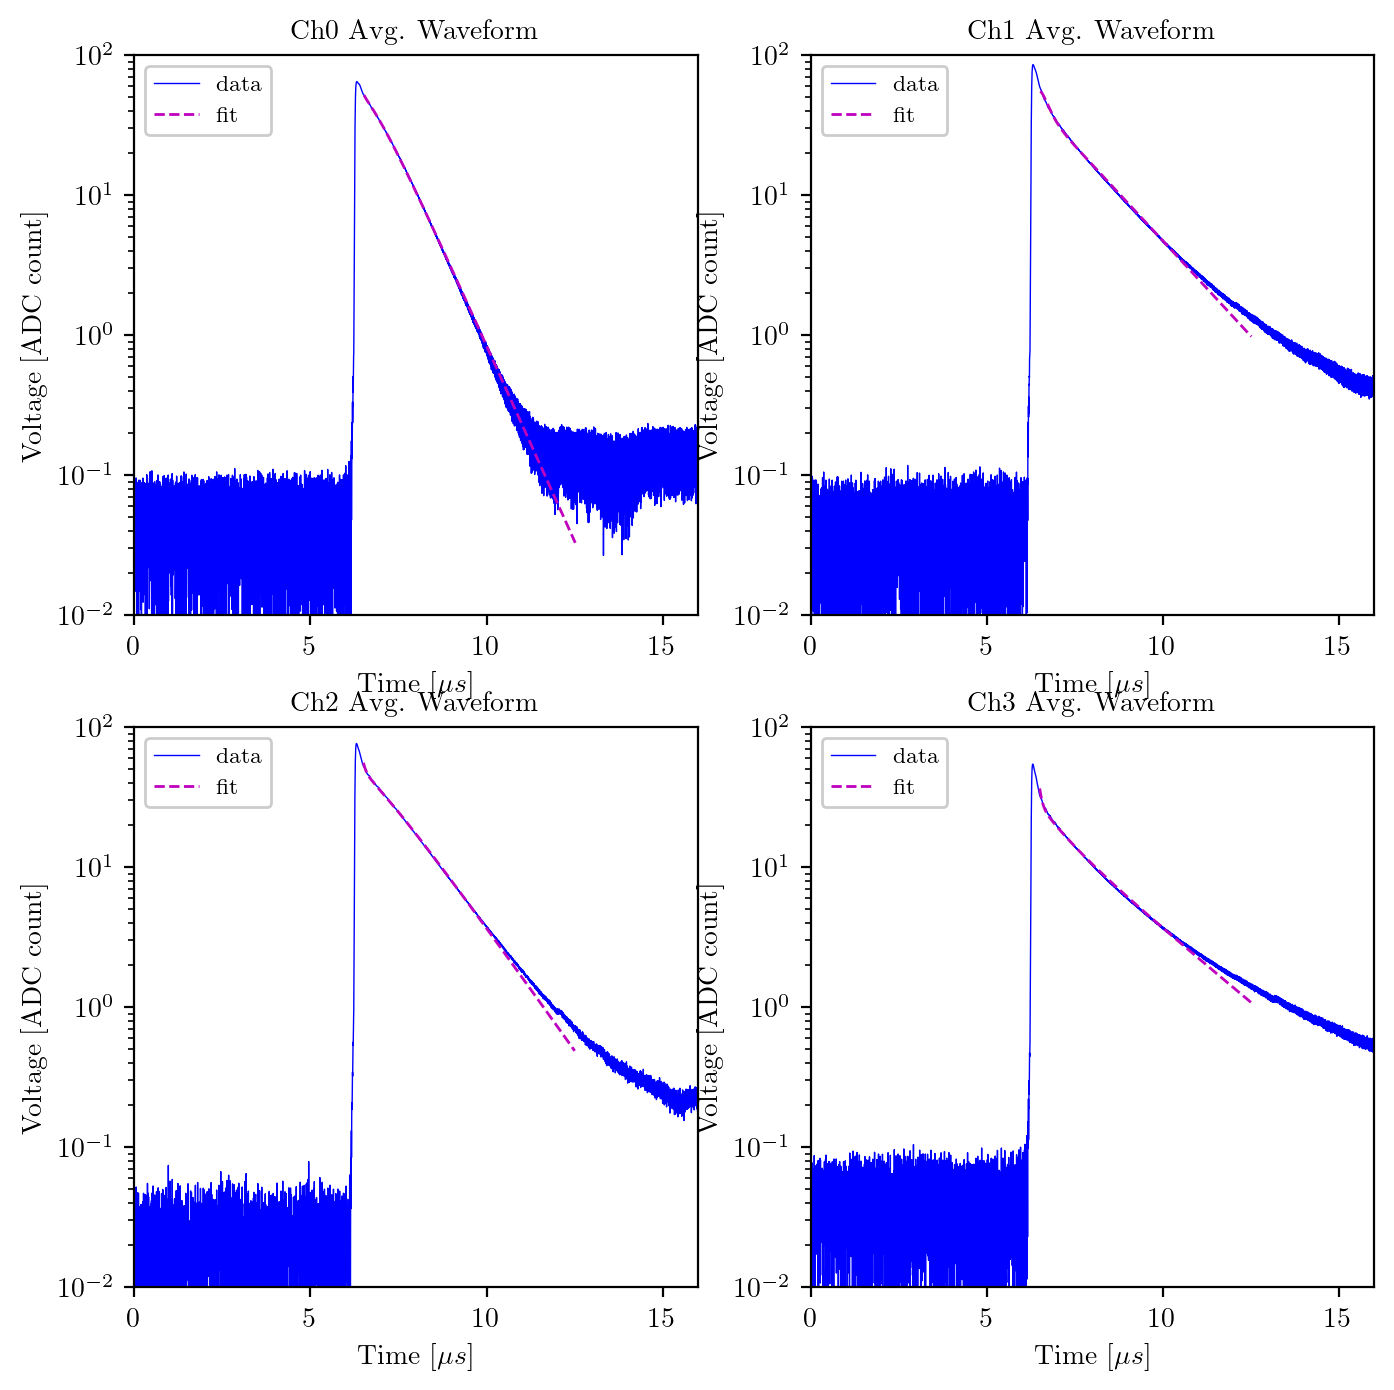

In [6]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
A1 = [2.87034549074171, 4.56530440419285, 4.34100691988196, 4.6130995887607]
TAU1 = [0.0444273100352291, 0.101583182633407, 0.07246236377296, 0.0718649983147296]
A2 = [3.02004825336753, 1.03860477405824, 1.42205954757012, 0.783024106669865]
TAU2 = [0.39793842757296, 0.733531780706409, 0.702539511527978, 0.710143874389766]

for i,dset in enumerate(ds1107_gamma):
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
              
        t0 = dset.ch[ch].trigger_position+int(0.2/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        if i==0:
            plt.subplot(2,2,ch+1)
            plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
            plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
        
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,16)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# plt.figure(1, figsize=(3,3))
# for ch in range(4):
#     plt.errorbar(np.arange(5), [dset_.ch[ch].tau_triplet[0] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[0]], yerr=[dset_.ch[ch].tau_triplet[1] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[1]], label='ch{}'.format(ch))
# plt.xlim(-1, 5)
# plt.ylim(1, 1.7)
# plt.legend()
# plt.ylabel(r'Triplet lifetime [$\mu s$]')
# plt.xticks(np.arange(5),labels=dscrp1006+['10-07'])

In [8]:
# bottom tile gain 65V
# 
# top tile gain 65V
# [526.15408, 519.05546, 507.44070, 521.98428]

dir1107_on = []
#dir1108_on = []
for i in range(16):
    dir1107_on.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/{}/'.format(i))
    #dir1108_on.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_overnight/{}/'.format(i))    
ds1107_on = []
#ds1108_on = []
for i,subdir in enumerate(dir1107_on):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=[518.84503, 510.84132, 504.40531, 457.59589])
    for ch in range(4):
        print(subdir)
        data.ch[ch].path = subdir
        data.ch[ch].read_data()
        data.ch[ch].baseline_subtraction()
        data.ch[ch].get_integral(prompt=0.5, long=5)
        data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 20*data.gain[ch]])
        data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds1107_on.append(data)

AttributeError: 'Dataset' object has no attribute 'Dataset'

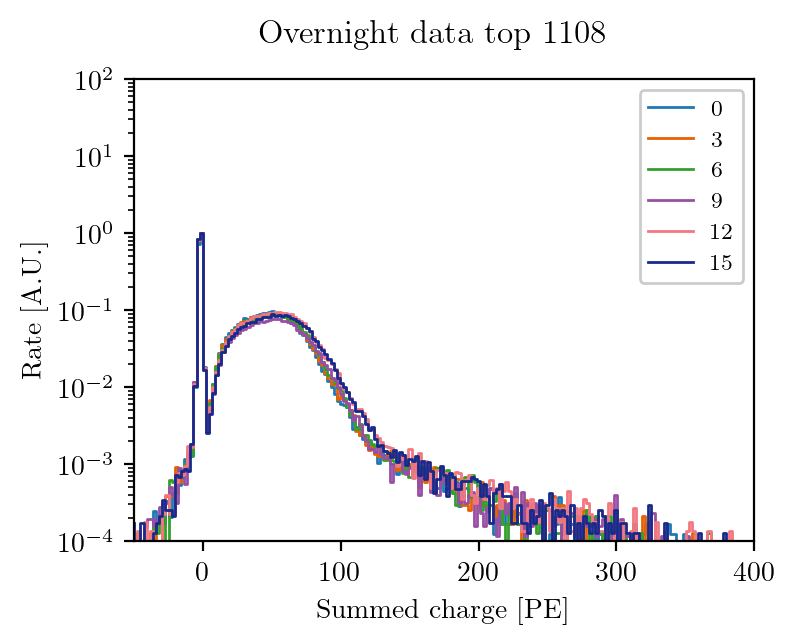

In [7]:
xmin = -50
xmax = 400
nbins = 200
bin_width = (xmax-xmin)/nbins
plt.figure()
hist = []
for i in range(len(ds1107_on)):
    dset = ds1107_on[i]
    h,hx = np.histogram(ds.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/np.max(h[20:])
    #h = h/ds.ch[0].cumulative_time/bin_width
    hist.append(h)
    if i%3==0:
        plt.step(hx[:-1], h, label='{}'.format(i), linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e2)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [A.U.]')
plt.suptitle('Overnight data bottom 1107')
plt.show()

ch0 A_S=146.892+/-20.856  TAU_S=0.0452+/-0.0056us  A_T=16.736+/-0.029  TAU_T=0.7720+/-0.0010us
ch1 A_S=22592121.931+/-162209357459.665  TAU_S=0.0000+/-0.0036us  A_T=9.664+/-0.115  TAU_T=1.4418+/-0.0120us
ch2 A_S=24802592.049+/-81116918068.951  TAU_S=0.0000+/-0.0013us  A_T=10.237+/-0.032  TAU_T=1.2171+/-0.0028us
ch3 A_S=45120155.267+/-259274452157.150  TAU_S=0.0000+/-0.0018us  A_T=8.592+/-0.055  TAU_T=2.0175+/-0.0113us
ch0 A_S=143.616+/-22.170  TAU_S=0.0452+/-0.0061us  A_T=16.654+/-0.030  TAU_T=0.7794+/-0.0011us
ch1 A_S=22323249.772+/-161786474256.860  TAU_S=0.0000+/-0.0036us  A_T=9.849+/-0.110  TAU_T=1.4385+/-0.0113us
ch2 A_S=24666876.418+/-78375144748.951  TAU_S=0.0000+/-0.0013us  A_T=10.378+/-0.031  TAU_T=1.2146+/-0.0026us
ch3 A_S=43020360.250+/-238473690008.043  TAU_S=0.0000+/-0.0018us  A_T=8.723+/-0.053  TAU_T=2.0059+/-0.0108us
ch0 A_S=139.525+/-20.449  TAU_S=0.0460+/-0.0059us  A_T=16.559+/-0.029  TAU_T=0.7942+/-0.0011us
ch1 A_S=21249214.260+/-153234867809.608  TAU_S=0.0000+/-0.003

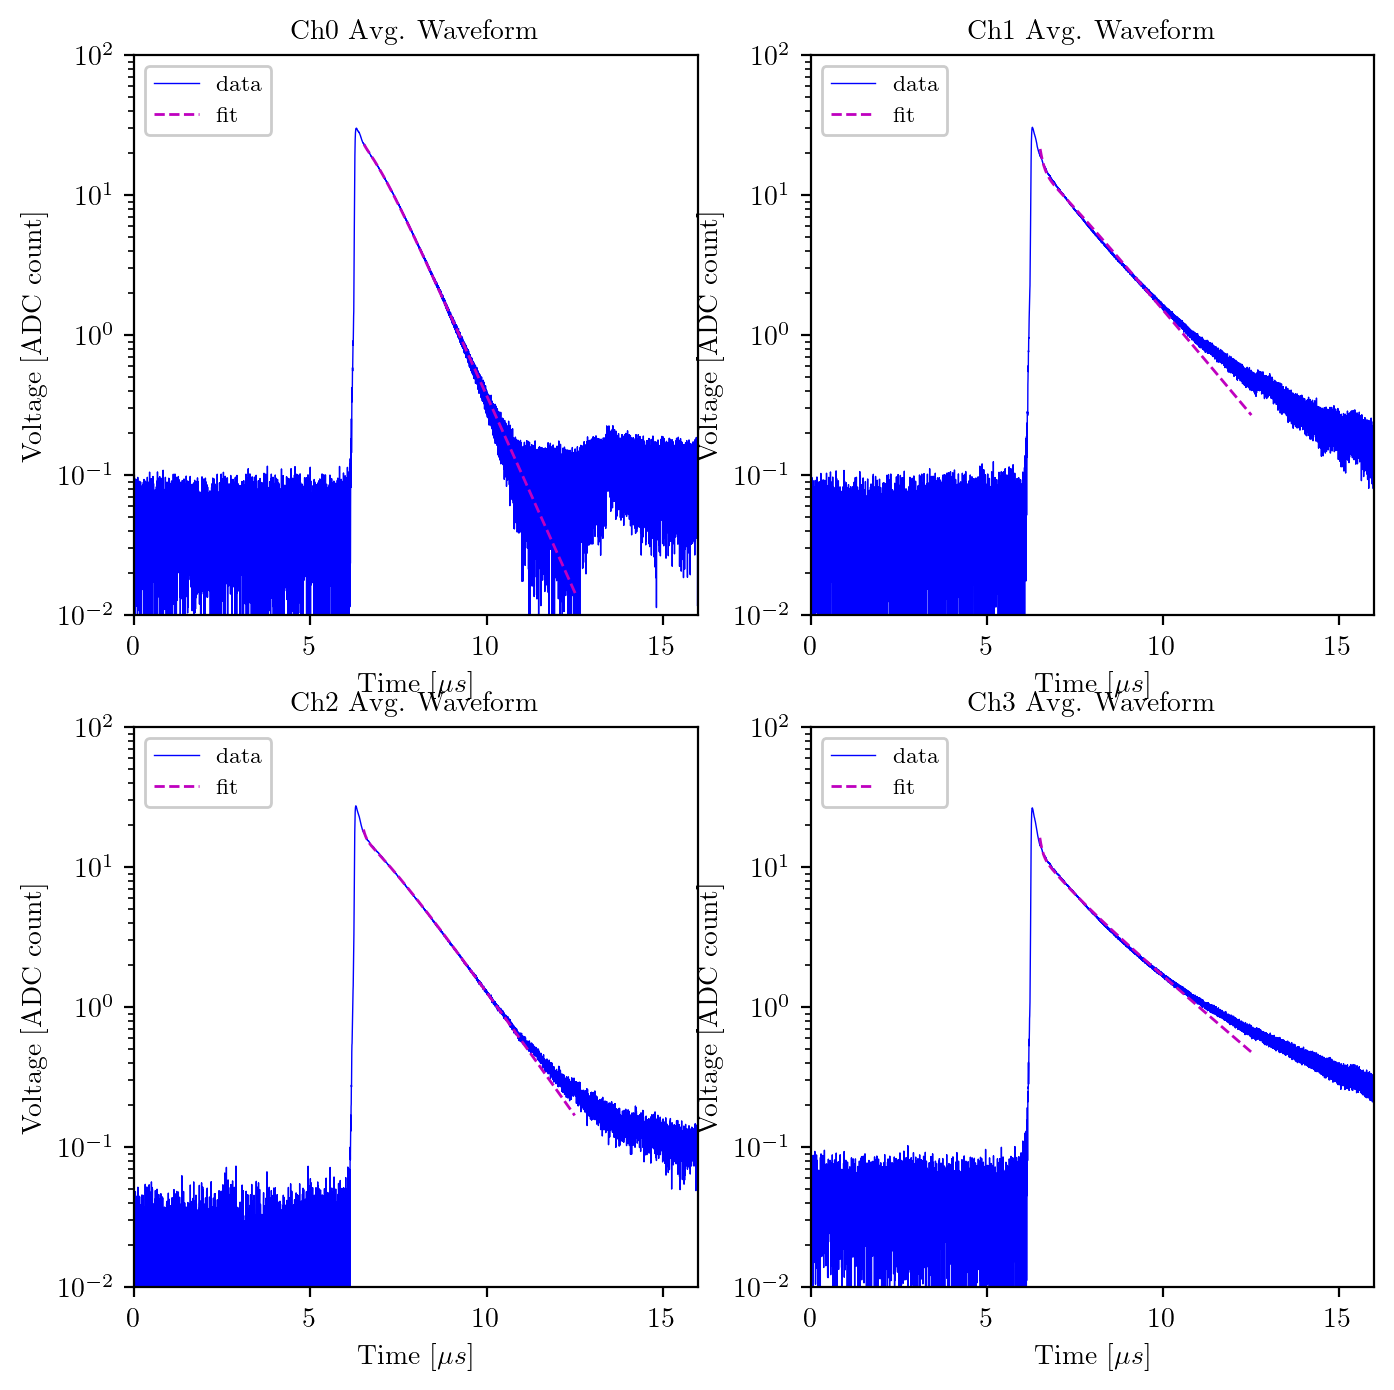

In [9]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
# SiPM response parameters bottom 65V
# A1 = [2.87034549074171, 4.56530440419285, 4.34100691988196, 4.6130995887607]
# TAU1 = [0.0444273100352291, 0.101583182633407, 0.07246236377296, 0.0718649983147296]
# A2 = [3.02004825336753, 1.03860477405824, 1.42205954757012, 0.783024106669865]
# TAU2 = [0.39793842757296, 0.733531780706409, 0.702539511527978, 0.710143874389766]
# SiPM response parameters top 65V
A1 = []
TAU1 = []
A2 = []
TAU2 = []

for i,dset in enumerate(ds1108_on):
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
        t0 = dset.ch[ch].trigger_position+int(0.2/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        if i==0:
            plt.subplot(2,2,ch+1)
            plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
            plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
    
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,16)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# plt.figure(1, figsize=(3,3))
# for ch in range(4):
#     plt.errorbar(np.arange(5), [dset_.ch[ch].tau_triplet[0] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[0]], yerr=[dset_.ch[ch].tau_triplet[1] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[1]], label='ch{}'.format(ch))
# plt.xlim(-1, 5)
# plt.ylim(1, 1.7)
# plt.legend()
# plt.ylabel(r'Triplet lifetime [$\mu s$]')
# plt.xticks(np.arange(5),labels=dscrp1006+['10-07'])

Text(0.5, 0.98, 'Bottom ch0 Overnight')

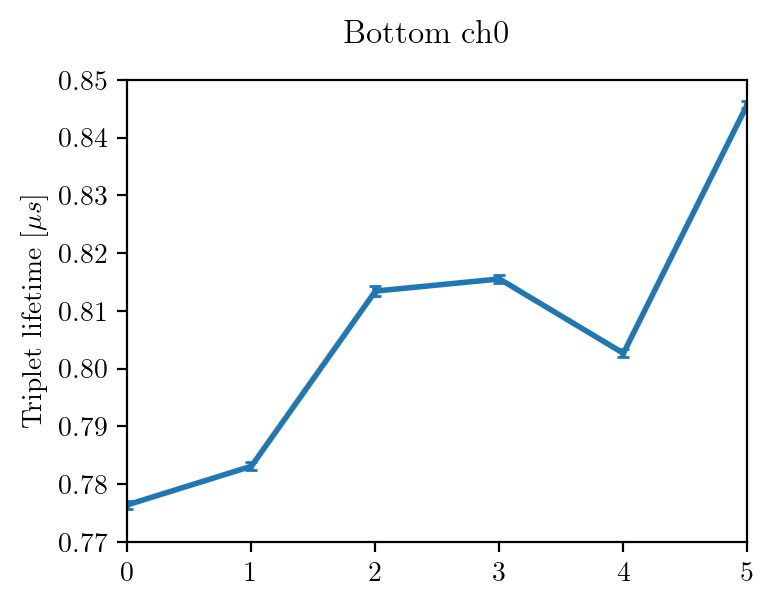

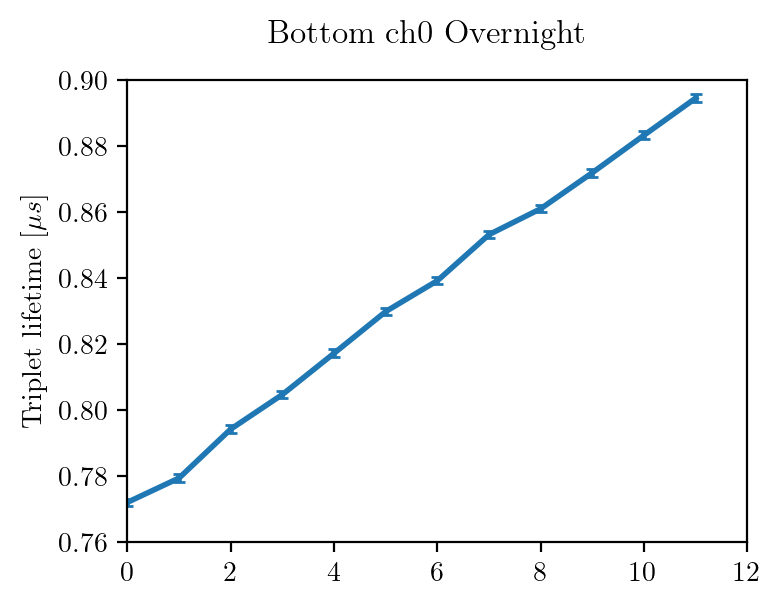

In [22]:
plt.figure(0)
plt.errorbar(np.arange(len(ds1107_gamma)), [dset.ch[0].tau_triplet[0] for dset in ds1107_gamma], yerr=[dset.ch[0].tau_triplet[1] for dset in ds1107_gamma])
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.suptitle('Bottom ch0')
plt.figure(1)
plt.errorbar(np.arange(len(ds1107_on)-1), [dset.ch[0].tau_triplet[0] for dset in ds1107_on[:-1]], yerr=[dset.ch[0].tau_triplet[1] for dset in ds1107_on[:-1]])
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.suptitle('Bottom ch0 Overnight')

# High-statistics data 1109

In [2]:
dir1109_top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
dir1109_bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/'


In [3]:
ds1109 = []
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1109_top, dir1109_bot]):
    for j in range(20):
        subdir = '{}{}/'.format(dir, j)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[i])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 20*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds1109.append(data)

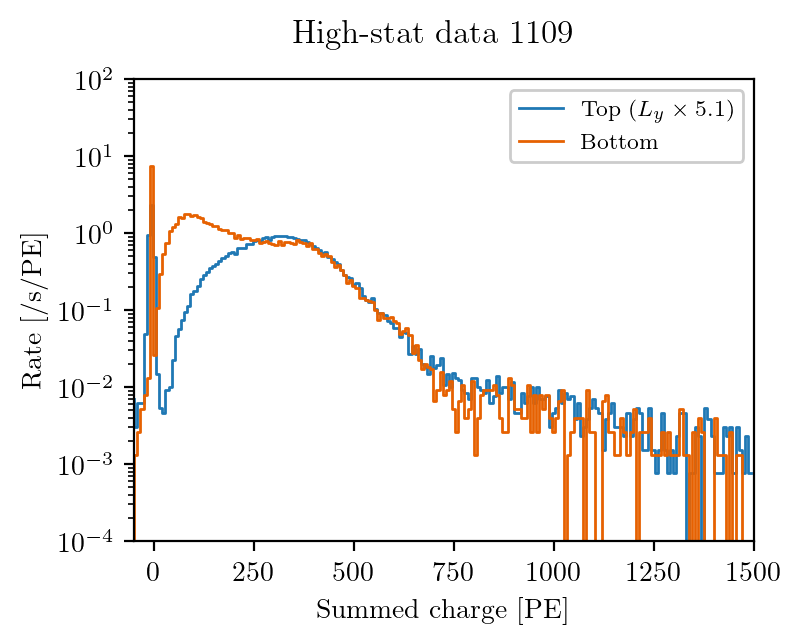

In [4]:
xmin = -50
xmax = 1500
nbins = 200
bin_width = (xmax-xmin)/nbins

plt.figure()
hist = []
#light yield ratio
lyr = 5.1
ly = [lyr, 1.0]
labels = [r'Top ($L_y\times{}$)'.format(lyr), 'Bottom']
for i,dset in enumerate(ds1109):
    h,hx = np.histogram(dset.summed_integral_pe*ly[i], bins=np.linspace(xmin,xmax,nbins))
    # h = h/np.max(h[20:])
    h = h/dset.ch[0].cumulative_time/bin_width
    hist.append(h)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e2)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [/s/PE]')
plt.suptitle('High-stat data 1109')
plt.show()

In [14]:
# Read SiPM pulse shape from csv
import csv
pulse_pars_top = []
pulse_pars_bot = []
with open('pulse_parameters_65V.csv') as f:
    r = csv.reader(f)
    line_count = 0
    for row in r:
        if line_count>0:
            if line_count<=4:
                pulse_pars_top.append([float(par) for par in row[1:]])
                print(pulse_pars_top[-1])
            else:
                pulse_pars_bot.append([float(par) for par in row[1:]])
                print(pulse_pars_bot[-1])
        line_count += 1


[2.003933785434135, 0.024575203170491864, 4.49550352641763, 0.2476099531800422]
[4.015880272096196, 0.0812454580695719, 1.7840165924258748, 0.4458558764303925]
[4.193902525291535, 0.0594226262128978, 1.7703397471365039, 0.40979090171729166]
[1.4032114898605919, 0.01345882233429407, 5.209052442678607, 0.27304419869499585]
[2.8703454907417143, 0.044427310035229144, 3.0200482533675346, 0.3979384275729603]
[4.565304404192848, 0.10158318263340703, 1.038604774058236, 0.733531780706409]
[4.341006919881959, 0.07246236377295998, 1.4220595475701183, 0.7025395115279778]
[4.613099588760699, 0.07186499831472958, 0.7830241066698652, 0.7101438743897659]


ch0 A_S=38.462+/-0.928  TAU_S=0.1134+/-0.0042us  A_T=16.268+/-0.222  TAU_T=1.2413+/-0.0150us
ch1 A_S=38.835+/-0.868  TAU_S=0.3261+/-0.0128us  A_T=12.920+/-1.041  TAU_T=1.2578+/-0.0551us
ch2 A_S=45.257+/-1.000  TAU_S=0.1324+/-0.0044us  A_T=15.368+/-0.227  TAU_T=1.5853+/-0.0215us
ch3 A_S=42.137+/-1.439  TAU_S=0.0763+/-0.0031us  A_T=10.202+/-0.108  TAU_T=1.7224+/-0.0195us
ch0 A_S=75.817+/-1.496  TAU_S=0.0793+/-0.0020us  A_T=14.117+/-0.158  TAU_T=1.2201+/-0.0125us
ch1 A_S=62.710+/-1.245  TAU_S=0.0989+/-0.0025us  A_T=9.024+/-0.121  TAU_T=2.2601+/-0.0338us
ch2 A_S=56.730+/-1.062  TAU_S=0.1186+/-0.0031us  A_T=10.526+/-0.168  TAU_T=1.6713+/-0.0244us
ch3 A_S=59.174+/-0.924  TAU_S=0.1693+/-0.0041us  A_T=11.735+/-0.246  TAU_T=2.0538+/-0.0411us


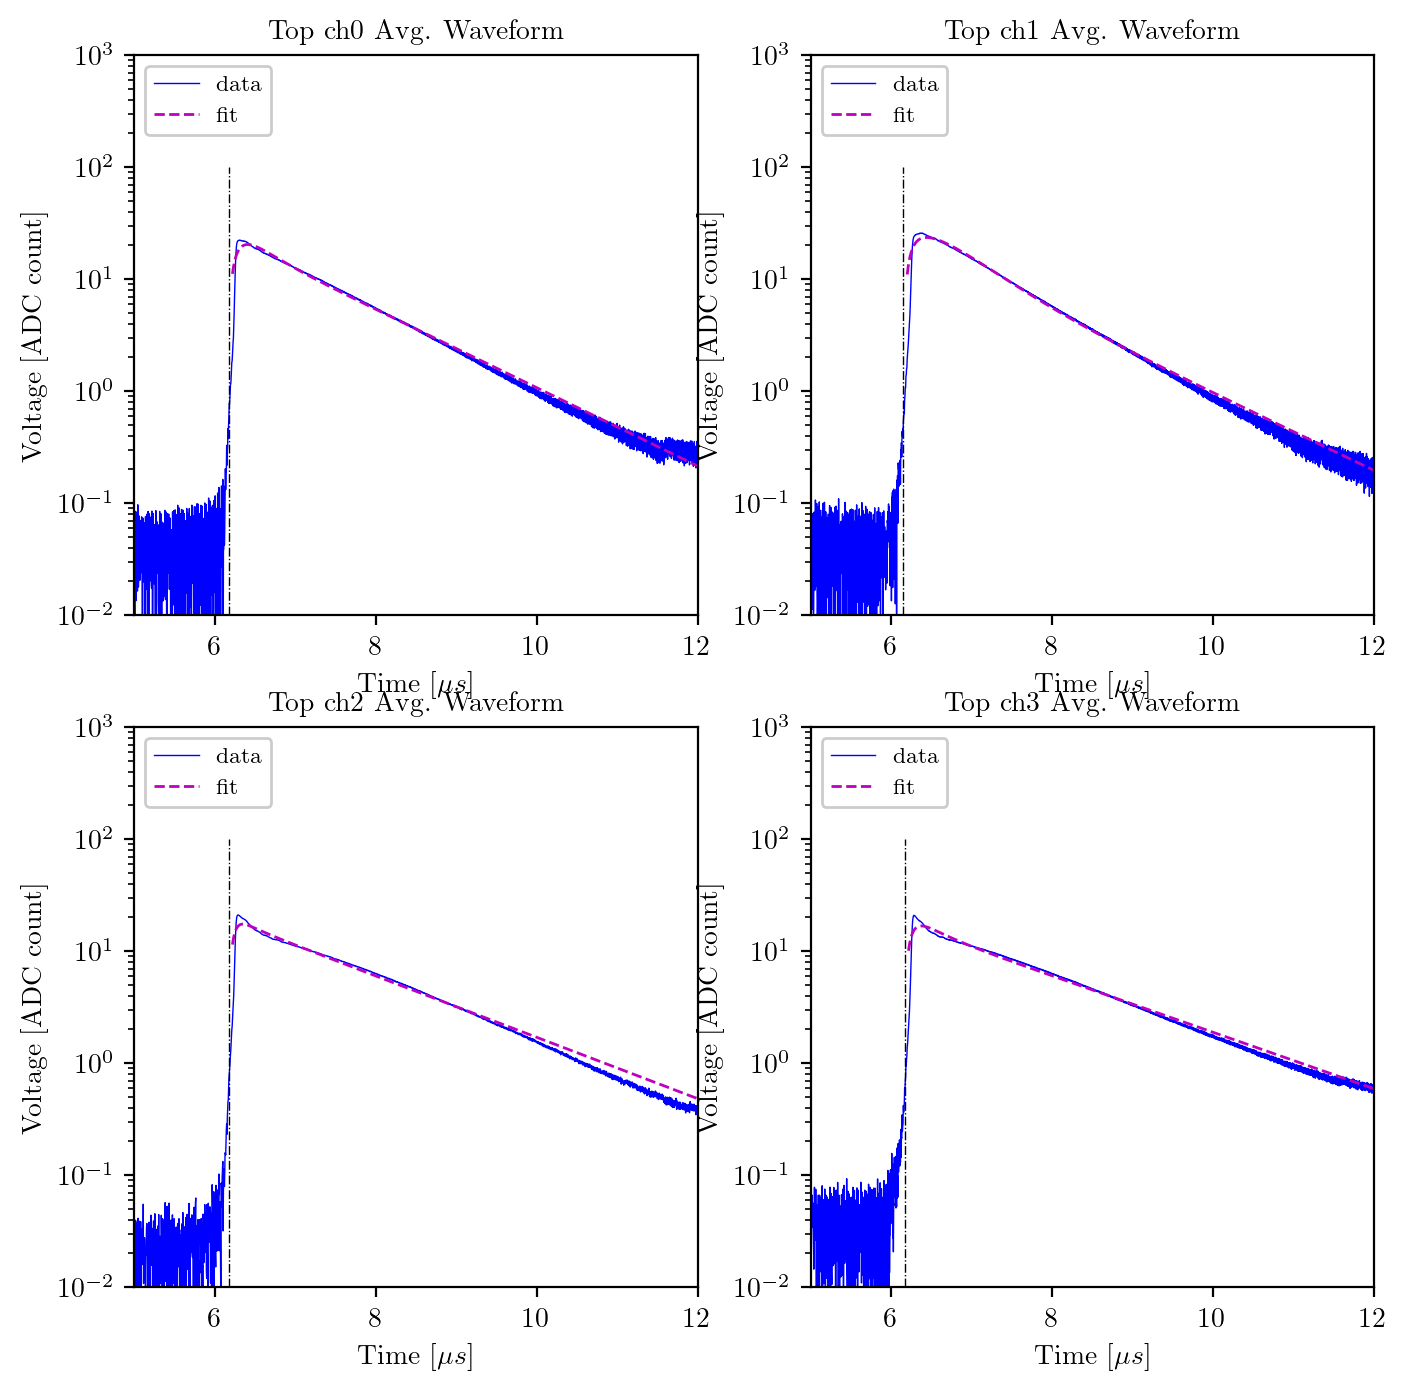

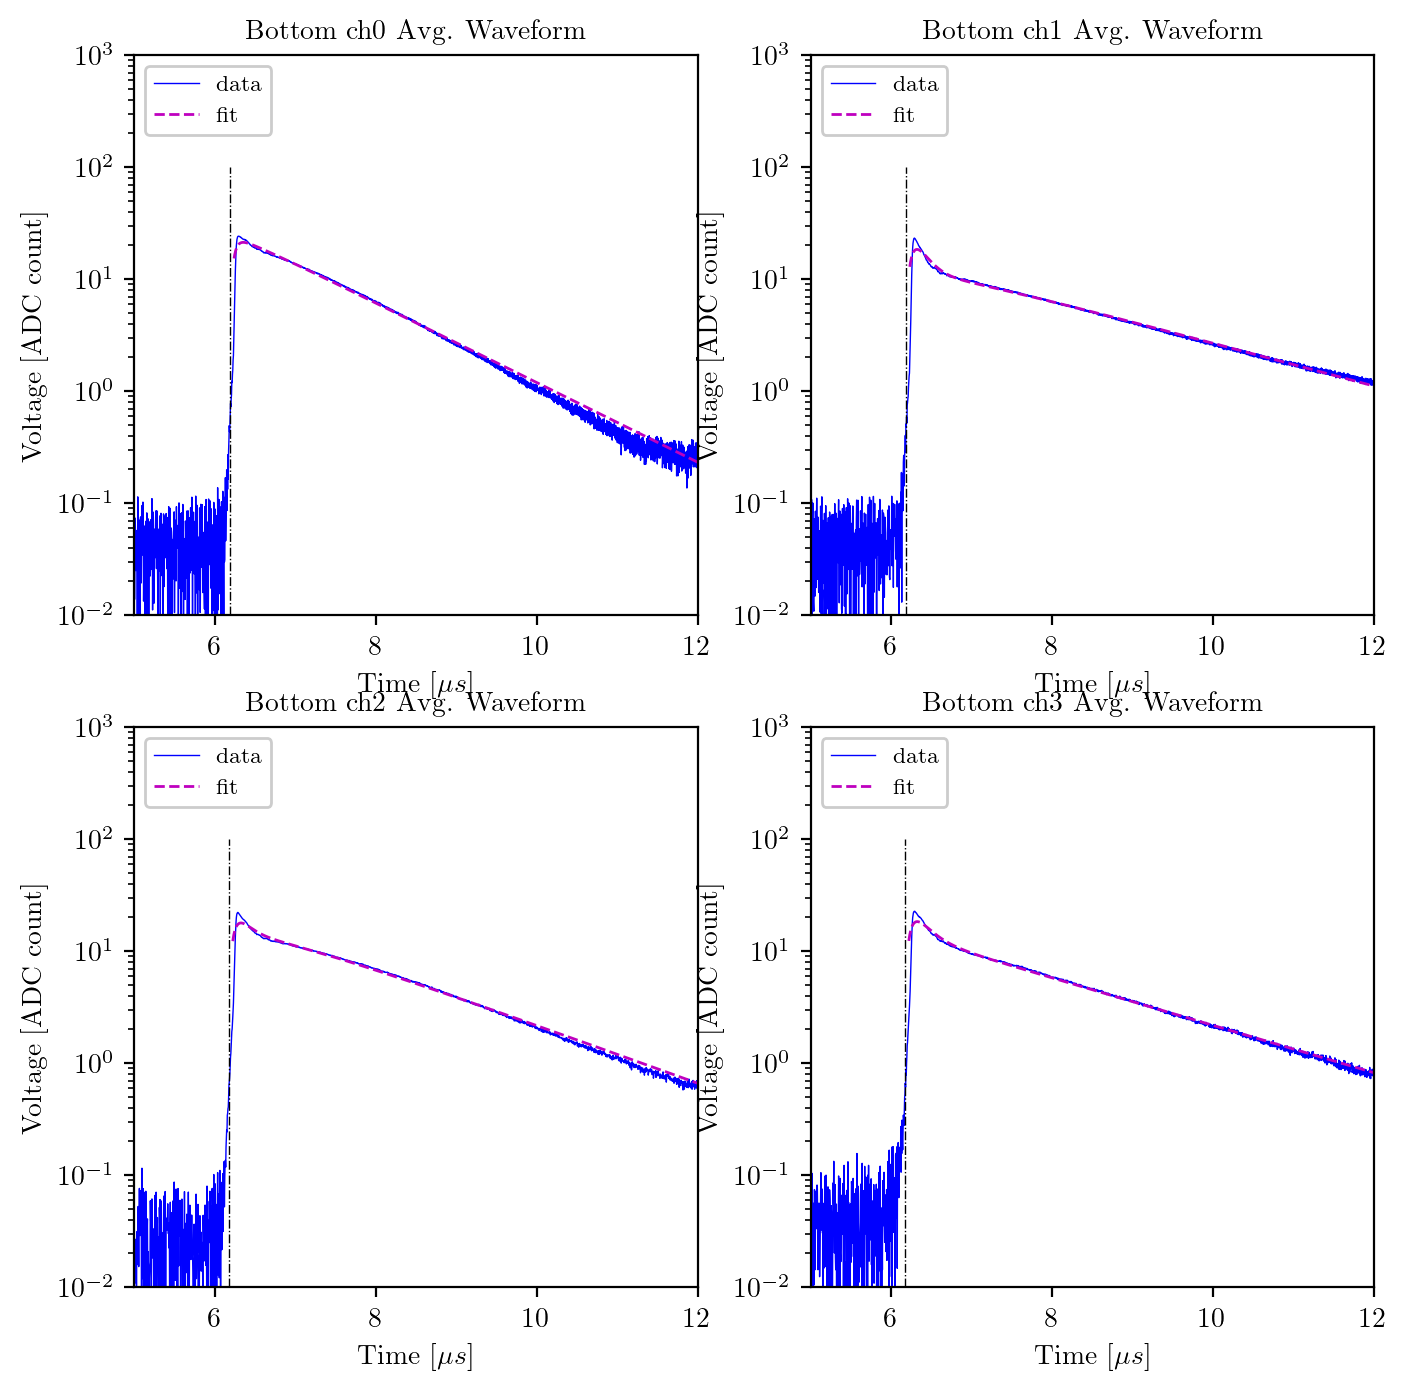

In [20]:
pos = ['Top', 'Bottom']
for i,dset in enumerate(ds1109):
    plt.figure(i,figsize=(8,8))
    for ch in range(4):
        while dset.ch[ch].avgwf[dset.ch[ch].trigger_position]<0.5:
            dset.ch[ch].trigger_position += 1
        if i==0:
            dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        else:
            dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        t0 = dset.ch[ch].trigger_position+int(0.05/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 20, 1.2], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
        t_trig = dset.ch[ch].trigger_position*dset.ch[ch].sample_step
        plt.plot([t_trig, t_trig], [1e-2, 1e2], 'k-.', linewidth=0.5)
        plt.title('{} ch{} Avg. Waveform'.format(pos[i],ch))
        plt.ylabel('Voltage [ADC count]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(5,12)
        plt.ylim(1e-2, 1e3)
        plt.yscale('log')

6.324
6.392
6.304
6.296


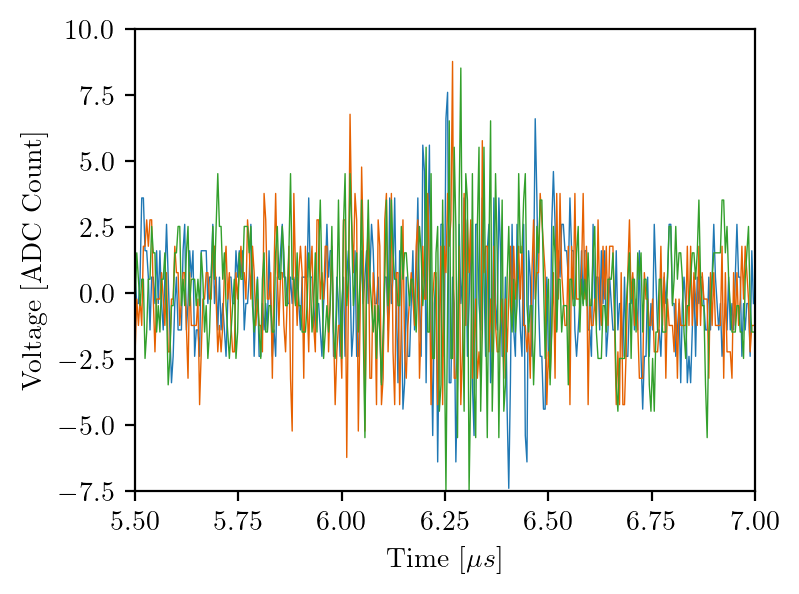

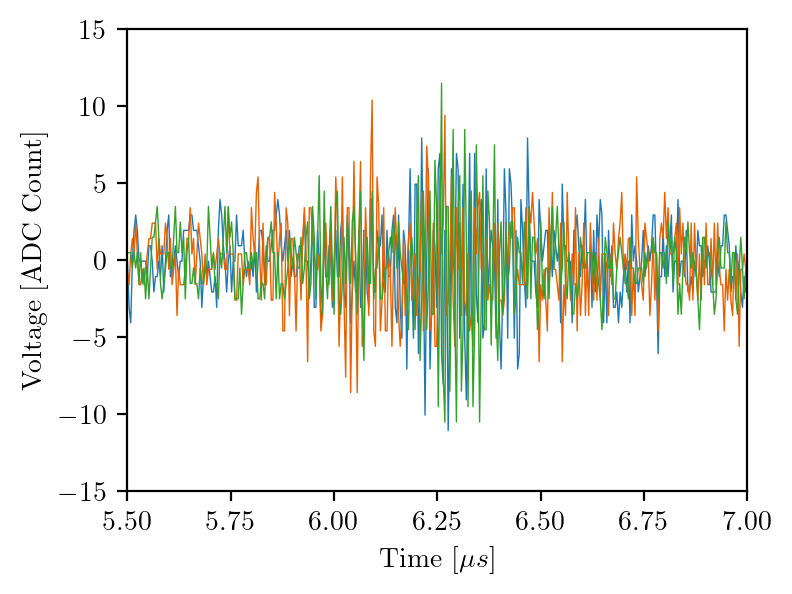

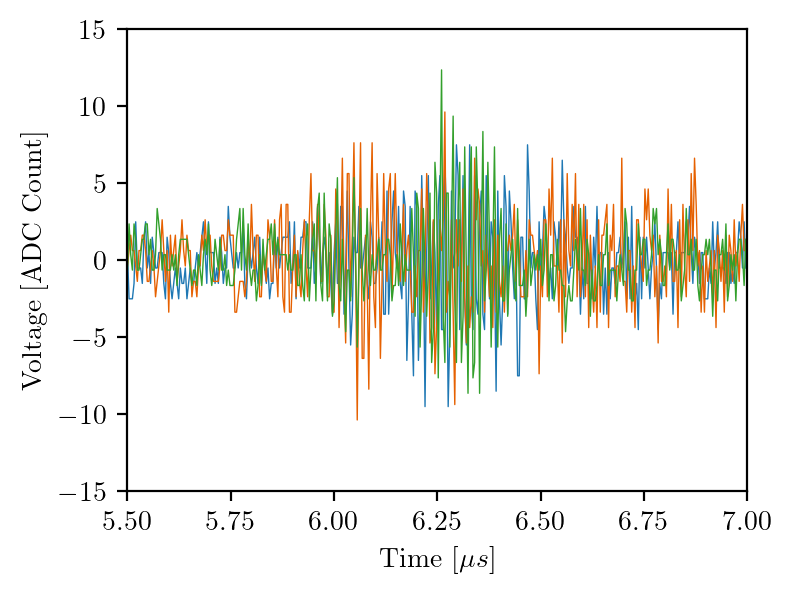

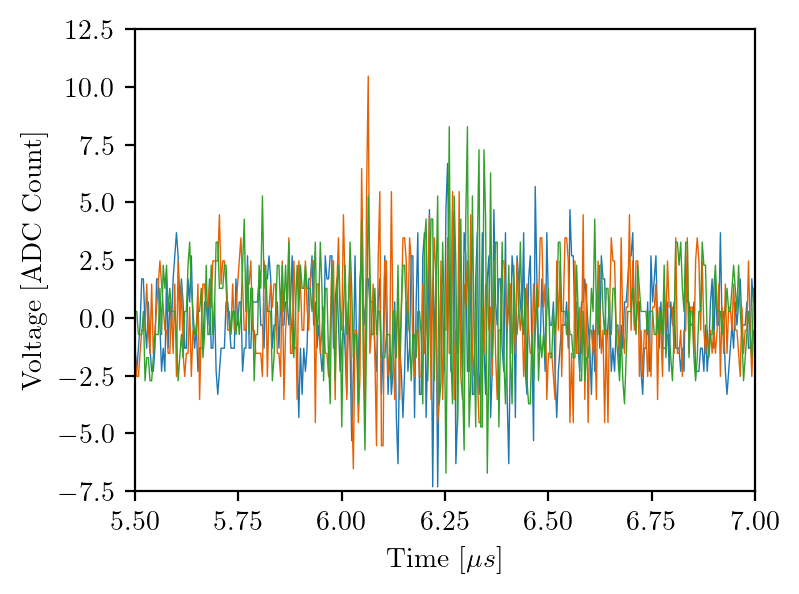

In [34]:
selected_wfid = ds1109[0].get_waveforms_id(count=10, integral_range=(-5,0))
tmin = 5.5
tmax = 7.0
tmin_sample = int(tmin/ds1109[0].ch[0].sample_step)
tmax_sample = int(tmax/ds1109[0].ch[0].sample_step)
for ch in range(4):
    print(ds1109[0].ch[ch].trigger_position*ds1109[0].ch[0].sample_step)
    plt.figure(ch)
    selected_wf = ds1109[0].ch[ch].get_waveforms(event_id=selected_wfid)
    for iwf in range(3):
        plt.plot(ds1109[0].ch[ch].time[tmin_sample:tmax_sample], selected_wf[iwf][tmin_sample:tmax_sample], linewidth=0.5)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [ADC Count]')